Welcome to JupyROOT 6.22/06
BDSIM output file - using DataLoader


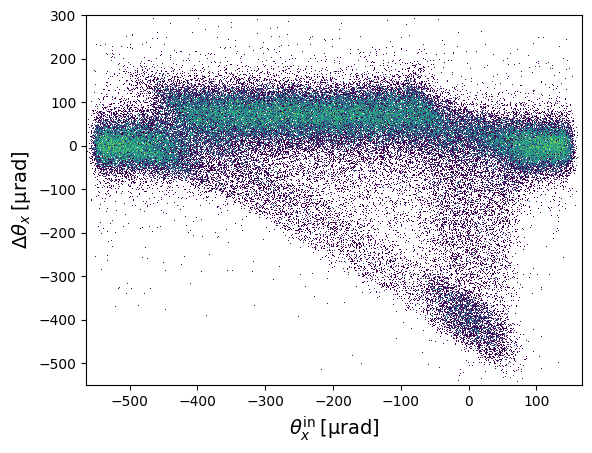

In [1]:
import ROOT
import pybdsim

import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt


def load_data(bdsim_outfile):
    
    data = pybdsim.Data.Load(bdsim_outfile)
    
    return data


def get_phaseSpace_data(data, incident_or_outgoing):
    
    if incident_or_outgoing == 'incident':
        phaseSpace_data = pybdsim.Data.PhaseSpaceData(data, 0)
        
    elif incident_or_outgoing == 'outgoing':  
        phaseSpace_data = pybdsim.Data.PhaseSpaceData(data, 1)
        
    else:
        raise ValueError("incident_or_outgoing must be either incident or outgoing.")
    
    return phaseSpace_data
    

def get_crystalExit_samplerData(data):
    
    return pybdsim.Data.SamplerData(data, 1)


def get_lCryst(crystal_samplerData):
    
    offset = 1e3 # um
    l_cryst = round(crystal_samplerData.data['S'][0]*1e6 - offset) # um
    
    return l_cryst
    

def get_energy(phaseSpace_data):
    
    energy = np.mean(phaseSpace_data.data['energy'])*1e9
    
    return energy


def get_critical_angle(energy, crystal):
    
    # Note: for the purposes of this code it is sufficient to have an approximate number for the critical angle.
    # Therefore, no distictions between different potential wells are made.
    if crystal == 'Si':
        U0 = 20 # eV
    else:
        raise ValueError("Crystals other than Si are not supported yet.")
    
    critical_angle = round(np.sqrt(2*U0/energy)*1e6 / 5)*5 # urad
    
    return critical_angle    


def get_distribution(plane, phaseSpace_data):
    
    if plane == 'h':
        u = phaseSpace_data.data['x']
        up = phaseSpace_data.data['xp']
    elif plane == 'v':
        u = phaseSpace_data.data['y']
        up = phaseSpace_data.data['yp'] 
    else:
        raise ValueError("Plane must be either horizontal (h) or vertical (v).")
        
    return u, up


def plot_distribution(x, xp, y, yp, fit_gaussian, show_plot, save_plot, dpi):
    
    x_edge = max(max(x), abs(min(x)))
    xp_edge = max(max(xp), abs(min(xp)))
    
    y_edge = max(max(y), abs(min(y)))
    yp_edge = max(max(yp), abs(min(yp)))
    
    if fit_gaussian:
        
        x_axis = np.arange(-x_edge, x_edge, 2*x_edge/1e3)
        xp_axis = np.arange(-xp_edge, xp_edge, 2*xp_edge/1e3)
        
        y_axis = np.arange(-y_edge, y_edge, 2*y_edge/1e3)
        yp_axis = np.arange(-yp_edge, yp_edge, 2*yp_edge/1e3)
        
        mu_x, sigma_x  = (np.mean(x), np.std(x))
        mu_xp, sigma_xp = (np.mean(xp), np.std(xp))
        
        mu_y, sigma_y  = (np.mean(y), np.std(y))
        mu_yp, sigma_yp = (np.mean(yp), np.std(yp))
     
    # Make the plot
    plt.figure(figsize=(10, 8))
    
    plt.subplot(2, 2, 1)
    plt.hist(x * 1e+3, density=True, bins=50, alpha=0.5)
    plt.title('Horizontal impacting distribution', fontsize=14)
    plt.xlabel('x [mm]', fontsize=14)
    plt.xlim([-x_edge*1e+3, x_edge*1e+3])
    if fit_gaussian:
        plt.plot(x_axis*1e+3, norm.pdf(x_axis*1e3, mu_x*1e3, sigma_x*1e3), color='red', linewidth=1.5)

    plt.subplot(2, 2, 2)
    plt.hist(y * 1e+3, density=True, bins=50, alpha=0.5)
    plt.title('Vertical impacting distribution', fontsize=14)
    plt.xlabel('y [mm]', fontsize=14)
    plt.xlim([-y_edge*1e+3, y_edge*1e+3])
    if fit_gaussian:
        plt.plot(y_axis*1e+3, norm.pdf(y_axis*1e+3, mu_y*1e3, sigma_y*1e3), color='red', linewidth=1.5)

    plt.subplot(2, 2, 3)
    plt.hist(xp * 1e+6, density=True, bins=50, alpha=0.5)
    plt.xlabel(r'$\theta_{x}^{\mathrm{in}}\:[\mathrm{\mu rad}]$', fontsize=14)
    plt.xlim([-xp_edge*1e+6, xp_edge*1e+6])
    if fit_gaussian:
        plt.plot(xp_axis*1e+6, norm.pdf(xp_axis*1e+6, mu_xp*1e6, sigma_xp*1e6), color='red', linewidth=1.5)

    plt.subplot(2, 2, 4)
    plt.hist(yp * 1e+6, density=True, bins=50, alpha=0.5)
    plt.xlabel(r'$\theta_{y}^{\mathrm{in}}\:[\mathrm{\mu rad}]$', fontsize=14)
    plt.xlim([-yp_edge*1e+6, yp_edge*1e+6])
    if fit_gaussian:
        plt.plot(yp_axis*1e+6, norm.pdf(yp_axis*1e+6, mu_yp*1e6, sigma_yp*1e6), color='red', linewidth=1.5)

    plt.tight_layout()  # Adjust spacing between subplots
    
    if save_plot:
        plt.savefig('impacting_distribution.png', dpi=dpi, bbox_inches='tight')
    
    if show_plot:
        plt.show()
    
    return


def get_surviving_primaries(crystal_samplerData, x, xp, y, yp):
    
    mask_surviving_primaries = crystal_samplerData.data['n'] == 1
    
    x = x[mask_surviving_primaries]
    xp = xp[mask_surviving_primaries]
    y = y[mask_surviving_primaries]
    yp = yp[mask_surviving_primaries]
    
    return x, xp, y, yp


def introduce_exp_resolution(data, mu_noise, sigma_noise):
    # introduce experimental resolution as a random gaussian noise
    noise = np.random.normal(mu_noise, sigma_noise, len(data))
    data = data + noise
    
    return data
    

def plot_angular_deflection(xp, delta_xp, bending_angle, show_plot, save_plot, dpi):

    # Define xlim and ylim [urad]
    # xlim = [-50,50]
    ylim = [-550,300]

    # Get bins
    bins_x = len(np.histogram_bin_edges(xp, bins='fd') -1)
    bins_y = len(np.histogram_bin_edges(delta_xp, bins='fd') -1)

    plt.hist2d(xp*1e6, delta_xp*1e6, cmap='viridis', bins=max(bins_x,bins_y), norm='log')
    plt.xlabel(r'$\theta_{x}^{\mathrm{in}}\:[\mathrm{\mu rad}]$', fontsize=14)
    plt.ylabel(r'$\Delta\theta_{x}\:[\mathrm{\mu rad}]$', fontsize=14)
    # plt.colorbar()

    # plt.xlim(xlim)
    plt.ylim(ylim)
    
    if save_plot:
        plt.savefig('planar_channeling.png', dpi=dpi, bbox_inches='tight')
    
    if show_plot:
        plt.show()
        
    return


def execute(incident_particles, outgoing_particles, bending_angle, crystal_samplerData, plot_init_distr, save_plot):
    
    # Get crystal length [um]
    l_cryst = get_lCryst(crystal_samplerData=crystal_samplerData)
    
    # Compute crystal bending radius [m]
    cryst_bendingR = l_cryst / bending_angle 
    
    # Get particle energy [eV]
    energy = get_energy(phaseSpace_data=incident_particles)
    
    # Compute critical angle [urad]
    critical_angle = get_critical_angle(energy=energy, crystal='Si')
    
    # Get initial distribution
    x_in, thetax_incident = get_distribution(plane='h', phaseSpace_data=incident_particles)
    y_in, thetay_incident = get_distribution(plane='v', phaseSpace_data=incident_particles)

    if plot_init_distr:
        # Plot initial distribution
        plot_distribution(x=x_in, xp=thetax_incident,
                        y=y_in, yp=thetay_incident,
                        fit_gaussian=True, 
                        show_plot=True,
                        save_plot=save_plot, dpi=600)


    # Filter initial distribution to get only the initial particles that survive
    x_in, thetax_incident, y_in, thetay_incident = get_surviving_primaries(crystal_samplerData=crystal_samplerData,
                                                                           x=x_in, xp=thetax_incident,
                                                                           y=y_in, yp=thetay_incident)   

    # Get outgoing distribution
    x_out, thetax_outgoing = get_distribution(plane='h', phaseSpace_data=outgoing_particles)
    y_out, thetay_outgoing = get_distribution(plane='v', phaseSpace_data=outgoing_particles)
    
    # Introduce experimental resolution
    thetax_incident = introduce_exp_resolution(data=thetax_incident, mu_noise=0, sigma_noise=5e-6)
    thetax_outgoing = introduce_exp_resolution(data=thetax_outgoing, mu_noise=0, sigma_noise=5e-6)

    # Compute angular deflection due to channeling
    delta_thetax = thetax_outgoing - thetax_incident
    
    # Plot angular deflection
    plot_angular_deflection(xp=thetax_incident, delta_xp=delta_thetax, bending_angle=bending_angle,
                            show_plot=True,
                            save_plot=save_plot, dpi=600)    
    
    
def main():
    
    plot_init_distr = False
    save_plot = False
    
    bending_angle = 400 # urad
    
    bdsim_outfile = "../output/output_6GeV_electrons_1e6part_forAngularDeflection.root"
    data = load_data(bdsim_outfile=bdsim_outfile)
    
    incident_particles = get_phaseSpace_data(data=data, incident_or_outgoing='incident')
    outgoing_particles = get_phaseSpace_data(data=data, incident_or_outgoing='outgoing')
    
    crystal_samplerData = get_crystalExit_samplerData(data)
    
    execute(incident_particles, outgoing_particles, bending_angle, crystal_samplerData, plot_init_distr, save_plot)
    

if __name__ == '__main__':
    
    main()